In [1]:
!git clone https://github.com/benihime91/leaf-disease-classification-kaggle.git
!pip install -r leaf-disease-classification-kaggle/requirements.txt --quiet

Cloning into 'leaf-disease-classification-kaggle'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 2376 (delta 31), reused 47 (delta 23), pack-reused 2310
Receiving objects: 100% (2376/2376), 65.34 MiB | 28.15 MiB/s, done.
Resolving deltas: 100% (1478/1478), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datashader 0.11.1 requires numba!=0.49.*,!=0.50.*,>=0.37.0, but you have numba 0.49.1 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!wandb login a74f67fd5fae293e301ea8b6710ee0241f595a63

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")
sys.path.append("/kaggle/working/leaf-disease-classification-kaggle/")
os.chdir("/kaggle/working/leaf-disease-classification-kaggle/")

In [4]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/pytorch-pretrained-models/se_resnext101_32x4d-3b2fe3d8.pth /root/.cache/torch/hub/checkpoints/

In [5]:
import logging
import colorlog

format_str = (
    "[%(cyan)s%(asctime)s%(reset)s][%(purple)s%(levelname)s%(reset)s]: %(message)s"
)
date_fmt = "%m/%d/%Y %H:%M:%S"

colors = {
    "DEBUG": "purple",
    "INFO": "green",
    "WARNING": "yellow",
    "ERROR": "red",
    "CRITICAL": "red",
}

formatter = colorlog.ColoredFormatter(format_str, date_fmt, log_colors=colors)
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)

logging.basicConfig(
    format=format_str, datefmt=date_fmt, level=logging.INFO, handlers=[stream_handler]
)

In [6]:
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(stream_handler)

## Import Utilitites

In [7]:
from hydra.utils import instantiate
from hydra.experimental import compose, initialize_config_dir
from omegaconf import OmegaConf, DictConfig

import gc
import albumentations as A
import wandb

import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from src.core import generate_random_id, seed_everything
from src.layers import apply_init, replace_activs
from src.lightning.core import LightningCassava
from src.lightning.callbacks import (
    WandbImageClassificationCallback,
    PrintLogsCallback,
    LitProgressBar,
)

## Initialize the Hydra config using the `Compose API`

In [8]:
overrides = [
    "network=seresnext101-snapmix",
    "mixmethod=snapmix",
    "mixmethod.conf_prob=0.5",
    "loss=bi-tempered-logistic-loss",
    "optimizer=adamw",
    "optimizer.weight_decay=0.1",
    "scheduler=linear-warmup",
    "augmentations=light-augs",
    "datamodule.curr_fold=0",
    "datamodule.num_workers=8",
    "datamodule.bs=16",
    "accumulate_batches=2",
    "lr_mult=10",
    "learning_rate=1e-03",
    "num_epochs=10",
]

with initialize_config_dir("/kaggle/working/leaf-disease-classification-kaggle/conf/"):
    conf = compose("17-01-20-seresnext101_32x4d", overrides=overrides)

In [9]:
print(OmegaConf.to_yaml(conf))

encoder: seresnext50_32x4d
accumulate_batches: 2
clip_grad_norm: 0
image_dims: 512
num_epochs: 10
learning_rate: 0.001
lr_mult: 10
augmentations:
  train:
  - _target_: albumentations.RandomResizedCrop
    height: ${image_dims}
    width: ${image_dims}
    p: 1.0
  - _target_: albumentations.Resize
    height: ${image_dims}
    width: ${image_dims}
    p: 1.0
  - _target_: albumentations.RandomBrightnessContrast
    brightness_limit: 0.1
    contrast_limit: 0.1
    p: 1.0
  - _target_: albumentations.HorizontalFlip
    p: 0.5
  - _target_: albumentations.VerticalFlip
    p: 0.5
  - _target_: albumentations.Normalize
    p: 1.0
    mean:
    - 0.42984136
    - 0.49624753
    - 0.3129598
    std:
    - 0.21417203
    - 0.21910103
    - 0.19542212
    max_pixel_value: 255.0
  - _target_: albumentations.pytorch.transforms.ToTensorV2
    p: 1.0
  valid:
  - _target_: albumentations.Resize
    height: ${image_dims}
    width: ${image_dims}
    p: 1.0
  - _target_: albumentations.Normalize
  

## Instantiate objects from the config file

In [10]:
seed = seed_everything(conf.general.random_seed)

if conf.general.unique_idx is None:
    conf.general.unique_idx = generate_random_id()

# save model name
model_name = (
    f"{conf.encoder}-fold={conf.datamodule.curr_fold}-{conf.general.unique_idx}"
)

log.info(f"Seed for the experiment : {seed}")
log.info(f"Unique id for the experiment : {conf.general.unique_idx}")
log.info(f"Saved model name: {model_name}")

[01/17/2021 18:31:09][INFO]: Seed for the experiment : 42
[01/17/2021 18:31:09][INFO]: Unique id for the experiment : 2b38b748
[01/17/2021 18:31:09][INFO]: Saved model name: seresnext50_32x4d-fold=0-2b38b748


**Instantiate the `albumentation-augmentations` & `lightning-datamodule` from Hydra config**

In [11]:
# instantiate albumentation transformations
trn_augs = A.Compose([instantiate(augs) for augs in conf.augmentations.train])
val_augs = A.Compose([instantiate(augs) for augs in conf.augmentations.valid])

# instantiate the lightning-datamodule
datamodule = instantiate(conf.datamodule, train_augs=trn_augs, valid_augs=val_augs)

**Instantiate/build the model for training from Hydra config**

In [12]:
# instantiate the base model architecture + activation function
pretrained = instantiate(conf.network.model)
activ = instantiate(conf.activation)
model = instantiate(conf.network.transfer_learning_model, encoder=pretrained, act=activ)

# if activation function is not ReLU the replace the activations for the model
if conf.activation._target_ != "torch.nn.ReLU":
    replace_activs(model.encoder, func=activ)

# init the weights of the final untrained layer
apply_init(model.fc, torch.nn.init.kaiming_normal_)

In [13]:
# check model
print(model)

SnapMixTransferLearningModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [14]:
# init the LightningModule
lit_model = LightningCassava(model, conf)

**Instantiate `pytorch-lightning trainer`**

In [15]:
# initialize pytorch_lightning Trainer + Callbacks
print_cb = PrintLogsCallback()
print_cb.logger = log

cbs = [
    WandbImageClassificationCallback(log_conf_mat=True),
    LitProgressBar(),
    print_cb,
    pl.callbacks.LearningRateMonitor(conf.scheduler.scheduler_interval),
]

# init checkpoint callback
checkpoint_cb = ModelCheckpoint(monitor="valid/acc", save_top_k=1, mode="max",)

# init logger
wb_logger = WandbLogger(project=conf.general.project_name, log_model=True)

trainer= instantiate(conf.trainer, checkpoint_callback=checkpoint_cb, callbacks=cbs, logger=wb_logger,)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


## Start Training

Now that all the objects from the config has been istantiated we can start the training job

**Run lightning-lr_finder to find best initial learning_rate**

In [16]:
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(lit_model, datamodule=datamodule)

[01/17/2021 18:35:20][INFO]: Suggested LR's : 0.0004365158322401656


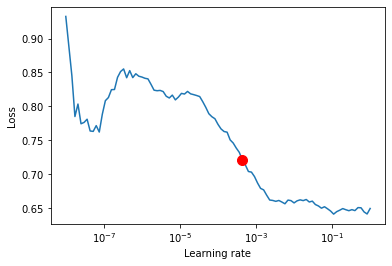

In [17]:
fig = lr_finder.plot(suggest=True)
log.info(f"Suggested LR's : {lr_finder.suggestion()}")
fig.show()

In [18]:
# update learning-rate of the model
new_lr = 0.0004
lit_model.hparams.learning_rate = new_lr

**Training starts**

In [19]:
# Start Train + Validation
trainer.fit(lit_model, datamodule=datamodule)

wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[01/17/2021 18:58:04][INFO]: Epoch 1 
[01/17/2021 18:58:04][INFO]: eta: 0:22:41 loss: 0.4682 acc: 0.6564 valid_loss: 0.1788 valid_acc: 0.8404
[01/17/2021 19:21:02][INFO]: Epoch 2 
[01/17/2021 19:21:02][INFO]: eta: 0:22:58 loss: 0.3461 acc: 0.7788 valid_loss: 0.1575 valid_acc: 0.8610
[01/17/2021 19:43:58][INFO]: Epoch 3 
[01/17/2021 19:43:58][INFO]: eta: 0:22:55 loss: 0.3252 acc: 0.7971 valid_loss: 0.1467 valid_acc: 0.8736
[01/17/2021 20:06:53][INFO]: Epoch 4 
[01/17/2021 20:06:53][INFO]: eta: 0:22:54 loss: 0.3307 acc: 0.7986 valid_loss: 0.1435 valid_acc: 0.8762
[01/17/2021 20:29:39][INFO]: Epoch 5 
[01/17/2021 20:29:39][INFO]: eta: 0:22:45 loss: 0.3214 acc: 0.8064 valid_loss: 0.1406 valid_acc: 0.8822
[01/17/2021 20:52:14][INFO]: Epoch 6 
[01/17/2021 20:52:14][INFO]: eta: 0:22:34 loss: 0.3105 acc: 0.8112 valid_loss: 0.1355 valid_acc: 0.8862
[01/17/2021 21:14:45][INFO]: Epoch 7 
[01/17/2021 21:14:45][INFO]: eta: 0:22:31 loss: 0.3046 acc: 0.8182 valid_loss: 0.1343 valid_acc: 0.8827
[01/17

1

In [20]:
# Laod in the best checkpoint and save the model weights
best_path = checkpoint_cb.best_model_path

# Testing Stage
res = trainer.test(datamodule=datamodule, verbose=True, ckpt_path=best_path)

[01/17/2021 22:01:37][INFO]: Finished !
[01/17/2021 22:01:37][INFO]: [Train] loss: 0.3063 acc: 0.8197
[01/17/2021 22:01:37][INFO]: [Test ] loss: 0.1298 acc: 0.8893


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': tensor(0.8893, device='cuda:0'),
 'test/loss': tensor(0.1298, device='cuda:0'),
 'train/acc': tensor(0.5385, device='cuda:0'),
 'train/acc_epoch': tensor(0.8197, device='cuda:0'),
 'train/acc_step': tensor(0.5385, device='cuda:0'),
 'train/loss': tensor(0.5147, device='cuda:0'),
 'train/loss_epoch': tensor(0.3063, device='cuda:0'),
 'train/loss_step': tensor(0.5147, device='cuda:0'),
 'valid/acc': tensor(0.8841, device='cuda:0'),
 'valid/loss': tensor(0.1341, device='cuda:0')}
--------------------------------------------------------------------------------



## Finish training/ save model weights/ clean up

In [21]:
# load in the best model weights
checkpoint = torch.load(best_path)
lit_model.load_state_dict(checkpoint["state_dict"])
log.info(f"Best weights loaded from checkpoint : {best_path}")

[01/17/2021 22:01:38][INFO]: Best weights loaded from checkpoint : /kaggle/working/leaf-disease-classification-kaggle/wandb/run-20210117_183521-19rqiwxa/files/kaggle-leaf-disease-hydra-cli/19rqiwxa/checkpoints/epoch=8.ckpt


In [22]:
# create model save dir
os.makedirs(conf.general.save_dir, exist_ok=True)
pth = os.path.join(conf.general.save_dir, f"{model_name}.pt")

# save the weights of the model
lit_model.save_model_weights(pth)

In [23]:
# upload trained weights to wandb
wandb.save(pth)

log.info("Finishing up !")

try:
    conf_path = os.path.join(args.general.save_dir, "configFile.yaml")
    OmegaConf.save(conf, f=conf_path)
    wandb.save(conf_path)
except:
    pass

wandb.finish()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
[01/17/2021 22:01:38][INFO]: Finishing up !


lr-AdamW/pg1,0.0
lr-AdamW/pg2,4e-05
train/loss_step,0.51474
train/acc_step,0.53846
epoch,9
_step,4816
_runtime,12377
_timestamp,1610920898
valid/loss,0.13414
valid/acc,0.88411
train/loss_epoch,0.30631


lr-AdamW/pg1,▁▂▄▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
lr-AdamW/pg2,▁▂▄▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
train/loss_step,▆█▆▆▅█▃▂▂▃▄▂▂▇▅▃▂▁▃▁▃▂▆▃▅▂▂▅▄▆▆▆▅▃▆▂▁▅▂▆
train/acc_step,▃▁▄▅▇▃▅▆▇▅▇▇▇▃▅▆▆█▆█▅▆▅▅▅▆▅▇▄▄▄▂▇▆▃▆▇▆▆▅
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/loss,█▅▃▃▃▂▂▁▂
valid/acc,▁▄▆▆▇█▇█▇
train/loss_epoch,█▃▂▂▂▁▁▁▁
